Working with the created Training Table

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]
training_table = pd.read_csv(file_name)


display(training_table.head())
print(training_table.shape)

Saving training_table.csv to training_table.csv


,log_return_realized_vol,log_return1_realized_vol,log_squared_wap_realized_vol,log_supply_demand_realized_vol,log_avg_wap_realized_vol,supply_demand_mean,diff_bid_price_mean,diff_ask_price_mean,log_diff_ask_price_realized_vol,log_diff_bid_price_realized_vol,...,order_count_min,order_count_max,order_count_sum,trade_vwap,trade_log_return_realized_vol,trade_count,trades_per_second,stock_id,time_id,target
0,0.004499,0.006999,0.008999,23.882098,0.004115,10.392625,0.000176,0.000151,10.163384,14.363368,...,1.0,12.0,110.0,1.003504,6.348098,40.0,0.066667,0,5,0.004136
1,0.001204,0.002476,0.002409,12.632736,0.001268,1.303403,0.000142,0.000135,5.828955,7.344976,...,1.0,6.0,57.0,1.000274,5.478355,30.0,0.050000,0,11,0.001445
2,0.002369,0.004801,0.004737,11.960647,0.002719,2.440987,0.000197,0.000198,10.545361,8.431766,...,1.0,8.0,68.0,0.998894,4.996022,25.0,0.041667,0,16,0.002168
3,0.002574,0.003637,0.005148,11.042210,0.002625,2.360404,0.000190,0.000108,6.001790,7.535458,...,1.0,15.0,59.0,0.998780,3.869189,15.0,0.025000,0,31,0.002195
4,0.001894,0.003257,0.003789,17.459754,0.001901,1.840490,0.000191,0.000109,7.145739,4.857366,...,1.0,17.0,89.0,0.999584,4.688625,22.0,0.036667,0,62,0.001747


(343144, 49)


In [2]:
#train test split and defining x and y
features = [col for col in training_table.columns if col not in ['stock_id', 'time_id', 'target']]
X = training_table[features]
y = training_table['target']

unique_time_ids = sorted(training_table['time_id'].unique())

split_point = int(0.8 * len(unique_time_ids))

train_time_ids = unique_time_ids[:split_point]

# Split the training_table based on time_id
X_train = training_table[training_table['time_id'].isin(train_time_ids)][features]
y_train = training_table[training_table['time_id'].isin(train_time_ids)]['target']
X_valid = training_table[~training_table['time_id'].isin(train_time_ids)][features]
y_valid = training_table[~training_table['time_id'].isin(train_time_ids)]['target']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (274493, 46)
y_train shape: (274493,)
X_valid shape: (68651, 46)
y_valid shape: (68651,)


In [3]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(random_state=42)

# Train the model
print("Training LightGBM model...")
lgbm.fit(X_train, y_train)
print("LightGBM model training complete.")

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11462
[LightGBM] [Info] Number of data points in the train set: 274493, number of used features: 46
[LightGBM] [Info] Start training from score 0.003907
LightGBM model training complete.


In [5]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the Root Mean Squared Percentage Error (RMSPE) function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Make predictions on the validation set
print("Making predictions on the validation set...")
y_pred_valid = lgbm.predict(X_valid)

# Evaluate on the validation set using RMSPE
valid_rmspe = rmspe(y_valid, y_pred_valid)
print(f"\nValidation RMSPE: {valid_rmspe:.6f}")

# To check for overfitting, let's also evaluate on the training set
print("Making predictions on the training set to check for overfitting...")
y_pred_train = lgbm.predict(X_train)

# Evaluate on the training set using RMSPE
train_rmspe = rmspe(y_train, y_pred_train)
print(f"Training RMSPE:   {train_rmspe:.6f}")



Making predictions on the validation set...

Validation RMSPE: 0.298207
Making predictions on the training set to check for overfitting...
Training RMSPE:   0.286029


Validation R-squared (R2) Score: 0.782160


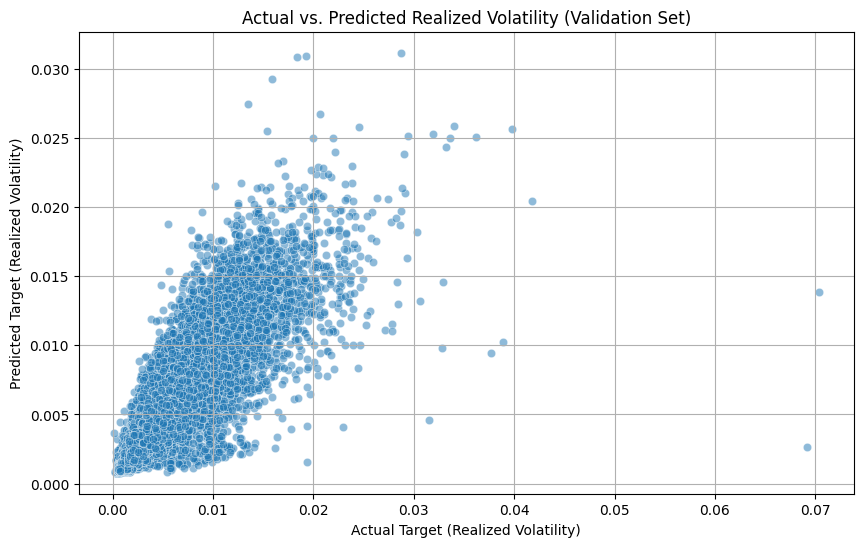

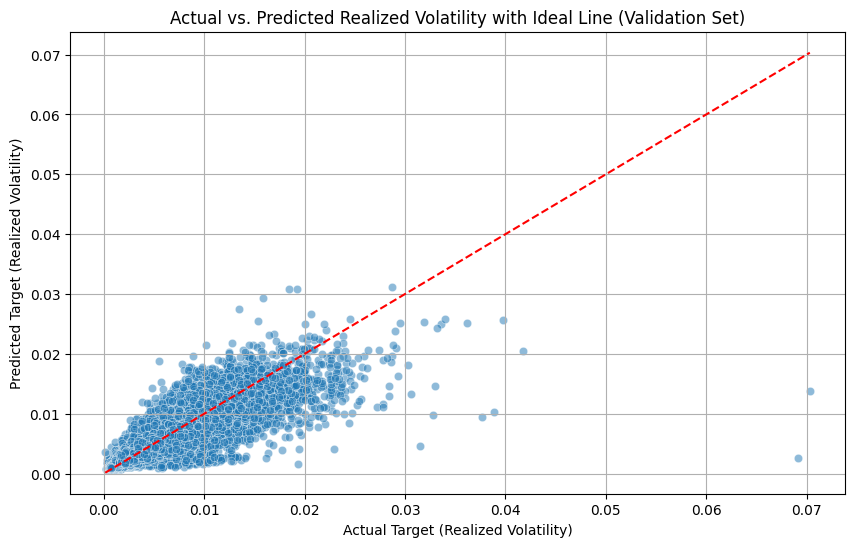

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Calculate R-squared score on the validation set
r2 = r2_score(y_valid, y_pred_valid)
print(f"Validation R-squared (R2) Score: {r2:.6f}")

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=y_pred_valid, alpha=0.5)
plt.xlabel("Actual Target (Realized Volatility)")
plt.ylabel("Predicted Target (Realized Volatility)")
plt.title("Actual vs. Predicted Realized Volatility (Validation Set)")
plt.grid(True)
plt.show()

# Optional: Add a diagonal line for perfect predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=y_pred_valid, alpha=0.5)
plt.xlabel("Actual Target (Realized Volatility)")
plt.ylabel("Predicted Target (Realized Volatility)")
plt.title("Actual vs. Predicted Realized Volatility with Ideal Line (Validation Set)")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--') # Diagonal line
plt.grid(True)
plt.show()